### To do 

gal['data'].shape = 3, npix, npix -> gal['img'], gal['mask'], gal['weight'].   'mask' needs to be boolean.

In [1]:
import matplotlib as mpl
import numpy as np
from glob import glob
import matplotlib.pyplot as plt 
import pickle

import astrobf
from astrobf.utils import mask_utils
from astrobf.utils.mask_utils import *
from astrobf.utils import gen_mask
from astrobf.morph import measure_morph

from astrobf.run import Full_exp
from astrobf.analysis.binary_clustering import *
from astrobf.analysis.utils import *

from astrobf.morph import custom_morph
from astrobf.analysis import multi_clustering as mucl
from astrobf.analysis.multi_clustering import labeler

import time

import random
import importlib

mpl.rcParams['savefig.facecolor'] = 'white'

## AX
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.ax_client import AxClient

np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## 1. Load the all-in-one data

### All_gals data

all-gals is a list of dictionaries, each of which contains 
(ndarray image, string image_name, and slices slice)


In [2]:
fn = "../../bf_data/Nair_and_Abraham_2010/all_gals.pickle"
all_gals = pickle.load(open(fn, "rb"))

all_gals = all_gals[1:] # Why the first galaxy image is NaN?

good_gids = np.array([gal['img_name'] for gal in all_gals])

# Append Asymmetry center to galaxies.
asym_center = pickle.load(open("./mean_center_asym.pickle", "rb"))

for ag in all_gals:
    ind = np.where(asym_center['id'] == ag['img_name'])[0]
    ag.update({'asym_center':np.array((asym_center['xc_asym'][ind],
                                       asym_center['yc_asym'][ind])).squeeze()})


In [3]:
# 2. Load galaxy catalog data and initial morph measurements
# Just in case, only for the initial morphology measurement, full results are saved. 

from astrobf.utils.misc import load_Nair
importlib.reload(astrobf.utils.misc)

cat_data = load_Nair('../../bf_data/Nair_and_Abraham_2010/catalog/table2.dat')
# pd dataframe

cat = cat_data[cat_data['ID'].isin(good_gids)]
# Leave only needed fields.

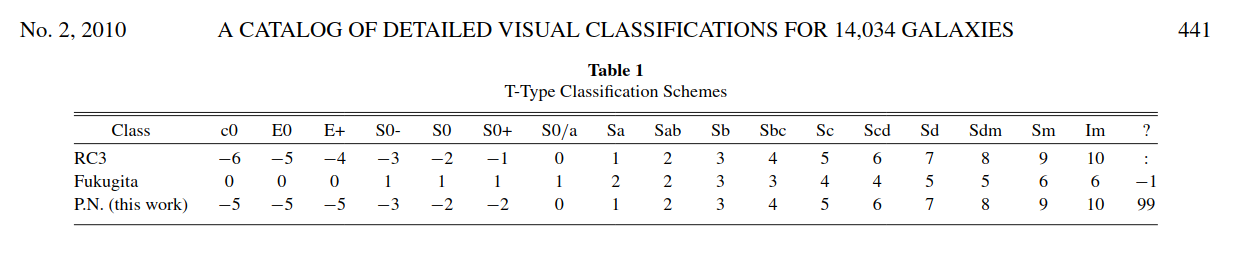

2 groups : [-5, -1],        [3,5]

4 groups : [-5, -1], [0,2], [3,5], [6,9]  

6 groups : [-5,-5], [-3, -1], [0,2], [3,4], [5,6], [7,9]

8 groups : [-5,-5], [-3, -1], [0,1], [2,3], [4,5], [6,7], [8,9], [10, ~]

# Run Bayesian Optimization loop

### Initialize BO loop -  Measure morphology features

In [101]:
## Runtime config.

fields = ['gini', 'm20', 'concentration']#'concentration']#, 'smoothness']
label_field = 'TT'

In [4]:
from functools import partial

def evaluate(params, 
             cluster_method="agglomerate", 
             eval_method='sample-weighted FMS', 
             debug=False, 
             return_result=False):
    plist =[{'b':params[f'b{i}'],
             'c':params[f'c{i}'],
            'dl':params[f'dl{i}'],
            'dh':params[f'dh{i}']} for i in range(ngroups)]

    result_list = []
    for i in range(ngroups):
        result_list.append(mucl.get_morph(sub_gals, 
                                          plist[i], 
                                          np.where(subcat['label'] == i)[0],
                                          fields)
                                          )
        if "bad" in result_list[-1]:
            return {"mymetric": (-1, 0), "total_flux":(0,0)}
    
    # merge and sort
    result_arr = np.concatenate(result_list)
    result_arr = result_arr[np.argsort(result_arr['id'])] # Sort first to apply 'searchsorted'
    inds = result_arr['id'].searchsorted(subcat["ID"])
    result_arr = result_arr[inds]
    
    Full_exp.add_ttype(result_arr, subcat)
    eval_metrics = Full_exp.do_ML(result_arr, partial(labeler, bins=this_bin), subcat, n_clusters=ngroups,
    #eval_metrics = do_ML(result_arr, partial(labeler, bins=this_bin), subcat, n_clusters=ngroups,
                         fields=fields, 
                         cluster_method=cluster_method,
#                         eval_weight='area'
                         )
    
    # save all metrics to a global list.
    all_metrics.append(eval_metrics)
    #mymetric = eval_metrics[0][1] # Homogenity
    #return eval_metrics
    #clustering_score = [val for (name, val) in eval_metrics if name == eval_method][0]
    clustering_score = eval_metrics[0][0]
    print(clustering_score)
    stderr = 0.0
    if return_result:
        return result_arr, {"mymetric": (clustering_score, stderr), "total_flux":(1,0)}
    else:
        return {"mymetric": (clustering_score, stderr), "total_flux":(1,0)}

def evaluate_singleTM(params, cluster_method="agglomerate", eval_method='sample-weighted FMS', debug=False):
    plist =[{'b':params[f'b{i}'],
             'c':params[f'c{i}'],
            'dl':params[f'dl{i}'],
            'dh':params[f'dh{i}']} for i in range(1)]

    result_list = []
    for i in range(ngroups):
        result_list.append(mucl.get_morph(sub_gals, 
                                          plist[0], 
                                          np.where(subcat['label'] == i)[0],
                                          fields)
                                          )
        if "bad" in result_list[-1]:
            return {"mymetric": (-1, 0), "total_flux":(0,0)}
    
    # merge and sort
    result_arr = np.concatenate(result_list)
    result_arr = result_arr[np.argsort(result_arr['id'])] # Sort first to apply 'searchsorted'
    inds = result_arr['id'].searchsorted(subcat["ID"])
    result_arr = result_arr[inds]
    
    Full_exp.add_ttype(result_arr, subcat)
    
    eval_metrics = Full_exp.do_ML(result_arr, partial(labeler, bins=this_bin), subcat, n_clusters=ngroups,
                                  fields=fields, 
                                  cluster_method=cluster_method,
                                  eval_weight='area')
    
    # save all metrics to a global list.
    all_metrics.append(eval_metrics)
    #mymetric = eval_metrics[0][1] # Homogenity
    #return eval_metrics
    clustering_score = [val for (name, val) in eval_metrics if name == eval_method][0]
    stderr = 0.0
    return {"mymetric": (clustering_score, stderr), "total_flux":(1,0)}

## analysis

In [6]:
importlib.reload(mucl)

exp_dir='./Experiments/'
suffix = 'concen'
cluster_method = 'ward'
fields = ['gini', 'm20', 'concentration', 'asymmetry']
fn_result = 'FMS_4G_SVM_concen'
ngroups = [2,4,6,8][1]
axc = AxClient.load_from_json_file(exp_dir+fn_result+'.json')

[INFO 07-02 11:22:46] ax.modelbridge.base: Leaving out out-of-design observations for arms: 123_0, 107_0, 128_0, 54_0, 94_0, 72_0, 112_0, 129_0, 127_0, 132_0, 67_0, 71_0, 130_0, 96_0, 124_0, 73_0, 131_0
[INFO 07-02 11:22:46] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 2 decimal points.


In [11]:
this_bin, bin_mask = mucl.gen_bin_n_mask(ngroups)        
ax_params = mucl.gen_tmo_param_sets(ngroups)

subcat = mucl.sample_in_bins(cat, ngroups, this_bin, bin_mask=bin_mask)

print("# of sub sample: {}".format(len(subcat)))

sub_gals = [gal for gal in all_gals if gal['img_name'] in subcat['ID']]

#all_metrics = pickle.load(open(exp_dir+fn_result+"_all_metrics.pickle", "rb"))
#axc = AxClient.load_from_json_file(exp_dir+fn_result+'.json')

# of sub sample: 9313


/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



IndexError: list index out of range

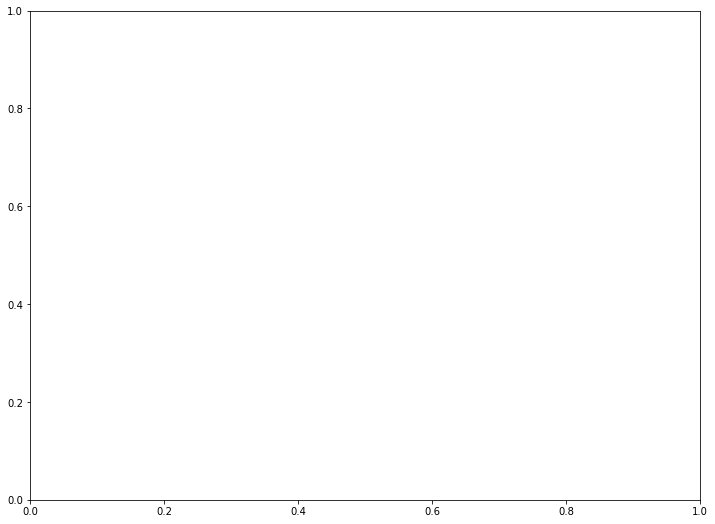

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(12,9)
for i in [0,1,2,5,9]:
    values =[al[i][1] for al in all_metrics] 
    ax.plot(values / np.max(values), label=all_metrics[0][i][0])
ax.legend()
plt.savefig(fn_result+"clustering_metric_evol.png")
plt.show()


print(axc.generation_strategy.trials_as_df)
render(axc.get_optimization_trace())

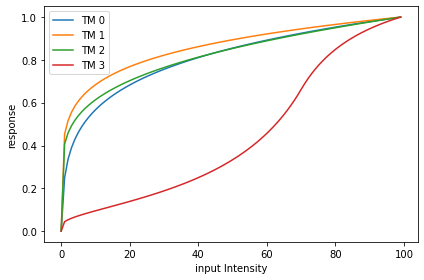

In [31]:
from astrobf.tmo import Mantiuk_Seidel

fig, ax = plt.subplots()

for i in range(ngroups):
    mapped = Mantiuk_Seidel(np.linspace(0,100,100),**mucl.ext_single_param(best_parameters, f"{i}"))
    
                            
    ax.plot( mapped / mapped.max(), label=f'TM {i}')
plt.legend()    
ax.set_xlabel("input Intensity")
ax.set_ylabel("response")
plt.tight_layout()
plt.savefig("TMOs_6G.png", dpi=144)

parameters들 normalize가 안 된듯?? 
각각의 모양은 그럴싸함. 

## Prototypical samples

In [7]:
from astrobf import analysis

plt.close('all')

In [12]:
best_parameters, values = axc.get_best_parameters()

plist = []
for i in range(ngroups):
    plist.append(mucl.ext_single_param(best_parameters, f"{i}"))
    
result_list = []
for i in range(ngroups):
    result_list.append(mucl.get_morph(sub_gals, 
                                      plist[i], 
                                      np.where(subcat['label'] == i)[0],
                                      fields)
                                      )

# merge and sort
result_arr = np.concatenate(result_list)
result_arr = result_arr[np.argsort(result_arr['id'])] # Sort first to apply 'searchsorted'
inds = result_arr['id'].searchsorted(subcat["ID"])
best_results = result_arr[inds]    


Full_exp.add_ttype(best_results, subcat)

Is every element matched?:  True


In [8]:
all_metrics=[]

In [13]:
best_parameters, values = axc.get_best_parameters()
best_results, mymetric = evaluate(best_parameters, cluster_method='ward', return_result=True)

<ipython-input-4-76064c1baa7f>:20: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-4-76064c1baa7f>:20: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-4-76064c1baa7f>:20: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-4-76064c1baa7f>:20: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
homogeneity_score


In [49]:
importlib.reload(Full_exp)

<module 'astrobf.run.Full_exp' from '/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py'>

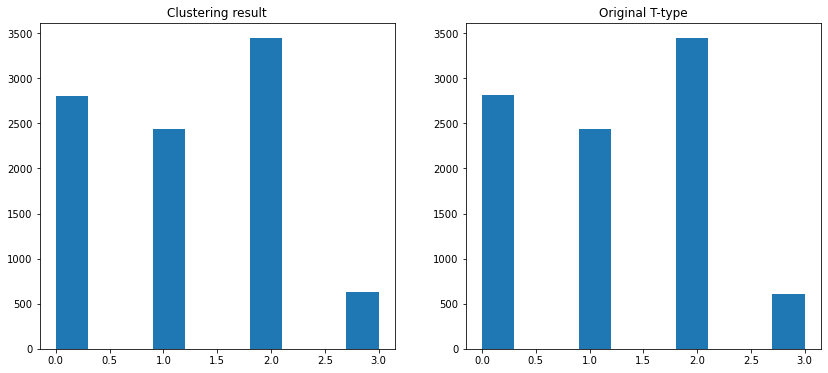

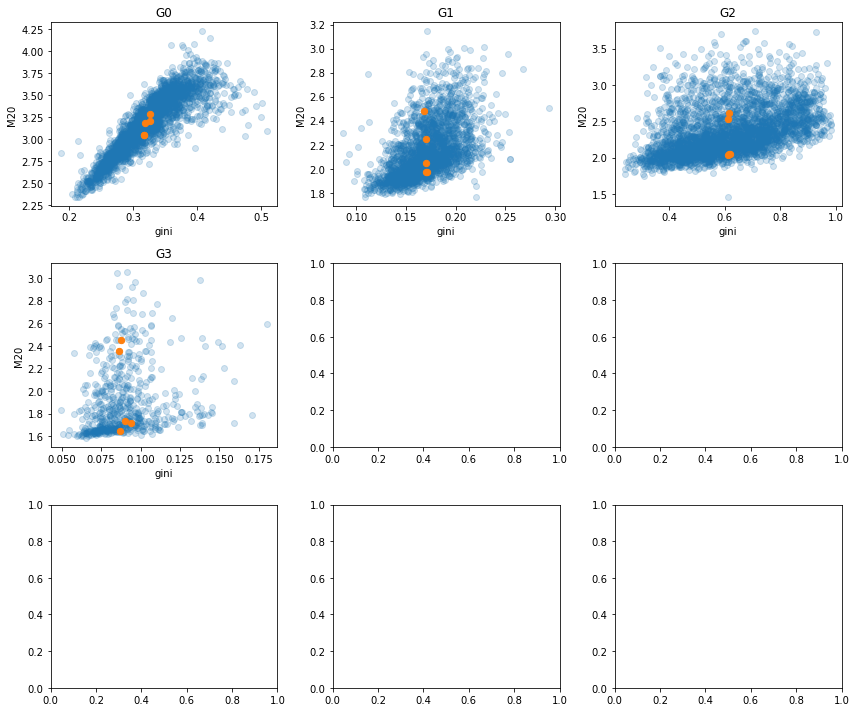

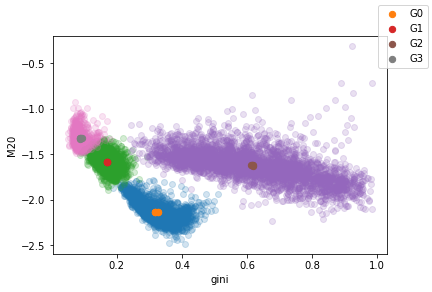

In [14]:
best_eval_metrics, preds = Full_exp.do_ML(best_results, 
                                                    partial(labeler, bins=this_bin), 
                                                    subcat,
                                                    fields=fields, 
                                                    n_clusters=ngroups,
                                                    return_cluster=True,
                                                    cluster_method="SVM",)
                                                    #eval_weight='area')

labels = preds# best_clustering.labels_

fig, axs = plt.subplots(1,2)
fig.set_size_inches(14,6)

axs[0].hist(labels)
axs[0].set_title("Clustering result")
axs[1].hist(labeler(subcat, bins=this_bin, field='TT'))
axs[1].set_title("Original T-type")

plt.savefig(fn_result+"clustering_result_vs_original_pop.png")
plt.show()

# Get centroids (typicals)
typicals = []

fig, axs = plt.subplots(3,3)
axs = axs.ravel()
fig.set_size_inches(12,10)

fig_sum, ax_sum = plt.subplots()
for i in range(ngroups):
    ax = axs[i]
    group = best_results[labels == i]
    
    t_ind = analysis.utils.get_typical_ind(group, n_samples=5)
    ax.scatter(group['gini'], group['concentration'], alpha=0.2)
    ax.scatter(group['gini'][t_ind], group['concentration'][t_ind], s=40)
    ax.set_xlabel("gini")
    ax.set_ylabel("M20")
    ax.set_title(f"G{i}")
    
    typicals.append([gal for gal in sub_gals if gal['img_name'] in group['id'][t_ind]])
    
    
    # all in one plot
    ax_sum.scatter(group['gini'], group['m20'], alpha=0.2)
    ax_sum.scatter(group['gini'][t_ind], group['m20'][t_ind], s=40, label=f"G{i}")
    ax_sum.set_xlabel("gini")
    ax_sum.set_ylabel("M20")


fig.tight_layout()
fig_sum.legend()
plt.savefig(fn_result+"clustering_summary_SVM_ward.png")
plt.show()

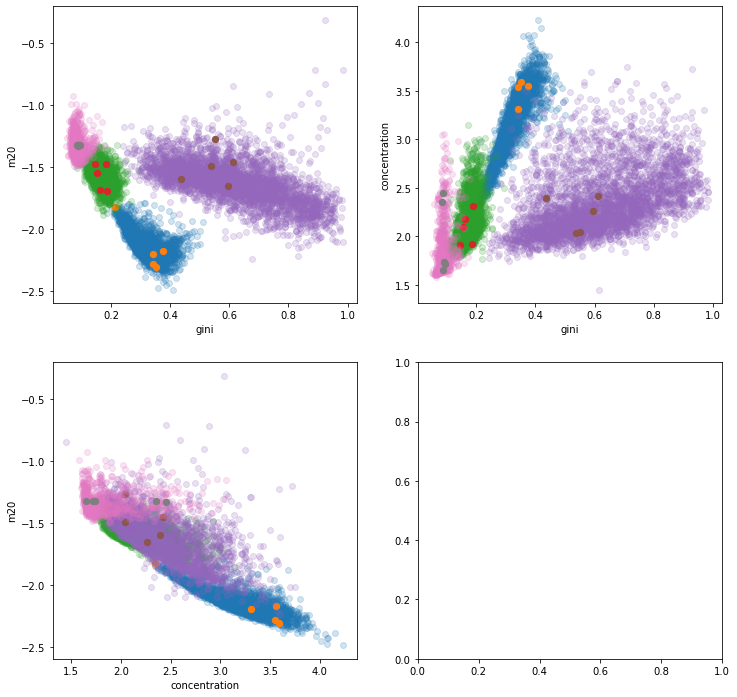

In [15]:
fig, axs = plt.subplots(2,2)
fig.set_size_inches(12,12)
axs = axs.ravel()
f1 = 'gini'
f2 = 'm20'
f3 = 'concentration' # 'asymmetry'

for i in range(ngroups):
    group = best_results[labels == i]
    axs[0].scatter(group[f1], group[f2], alpha=0.2)
    axs[0].scatter(group[f1][t_ind], group[f2][t_ind], s=40, label=f"G{i}")
    axs[0].set_xlabel(f1)
    axs[0].set_ylabel(f2)

    axs[1].scatter(group[f1], group[f3], alpha=0.2)
    axs[1].scatter(group[f1][t_ind], group[f3][t_ind], s=40, label=f"G{i}")
    axs[1].set_xlabel(f1)
    axs[1].set_ylabel(f3)

    axs[2].scatter(group[f3], group[f2], alpha=0.2)
    axs[2].scatter(group[f3][t_ind], group[f2][t_ind], s=40, label=f"G{i}")
    axs[2].set_xlabel(f3)
    axs[2].set_ylabel(f2)

plt.show()

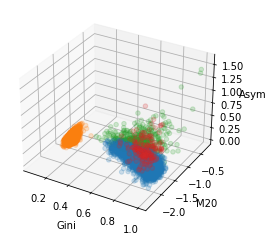

In [35]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#fig.set_size_inches(12,12)
for i in range(ngroups):
    group = best_results[best_clustering.labels_ == i]
    ax.scatter(group['gini'], group['m20'], group['asymmetry'], alpha=0.2)
    #ax.scatter(group['gini'][t_ind], group['m20'][t_ind], group['asymmetry'][t_ind], s=40, label=f"G{i}")

    #ax.scatter(group['gini'], group['asymmetry'], alpha=0.2)
    #ax.scatter(group['gini'][t_ind], group['asymmetry'][t_ind], s=40, label=f"G{i}")

    #axs[2].scatter(group['asymmetry'], group['m20'], alpha=0.2)
    #axs[2].scatter(group['asymmetry'][t_ind], group['m20'][t_ind], s=40, label=f"G{i}")

ax.set_xlabel("Gini")
ax.set_ylabel("M20")
ax.set_zlabel("Asym")
plt.show()

In [44]:
plt.close("all")

In [89]:
importlib.reload(mucl)

<module 'astrobf.analysis.multi_clustering' from '/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py'>

In [105]:
cmap = 'binary'
plt.set_cmap(cmap)
mucl.plot_group_comparison(typicals, plist, ngroups,
                          fn=exp_dir+fn_result+"groups_comp.png")

plt.set_cmap(cmap)
mucl.plot_group_comparison(typicals, plist, ngroups, simple_log=True,
                          fn=exp_dir+fn_result+"groups_log.png")


<Figure size 432x288 with 0 Axes>

## Typical samples at incremental points 

### Get the 'incremental' points

In [18]:
trace, t_ = axc.get_optimization_trace()

scores = np.array(trace['data'][0]['y'])
i_incr = [np.argmax(sc == scores) for sc in np.unique(scores)]

incr_params = [axc.get_trial_parameters(i) for i in i_incr]
print(len(incr_params))

6


<ipython-input-106-dacc673ca8d8>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-106-dacc673ca8d8>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-106-dacc673ca8d8>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-106-dacc673ca8d8>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator



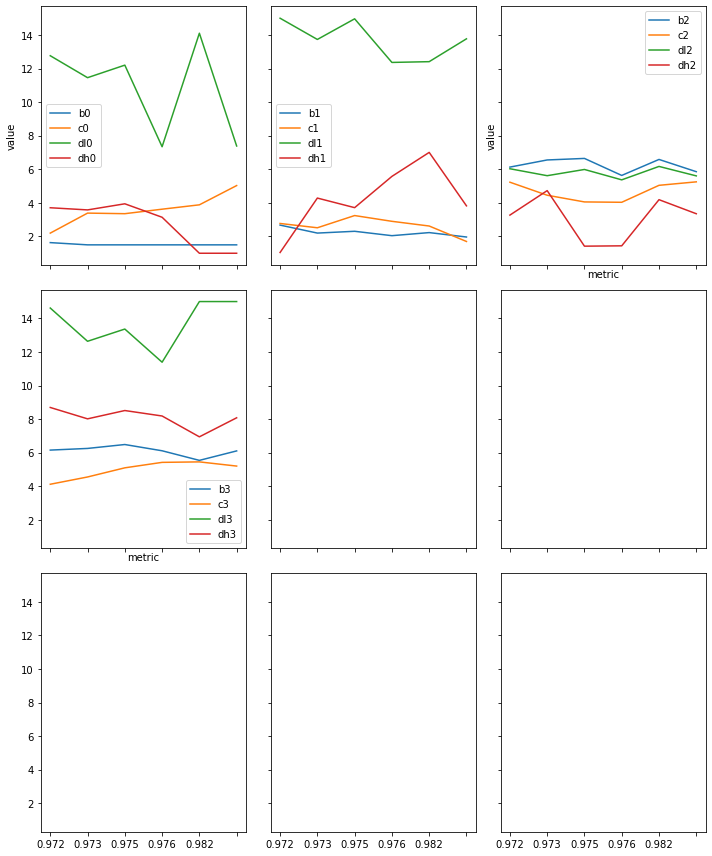

In [106]:
# Change of the parameters over time
param_arr = np.zeros(len(incr_params), dtype=[(key, 'f') for key in incr_params[0].keys()])

for i, params in enumerate(incr_params):
    for key, val in params.items():
        param_arr[key][i] = val

fig,axs = plt.subplots(3,3, sharex=True, sharey=True)
fig.set_size_inches(10,12)
axs = axs.ravel()
for i in range(ngroups):    
    ax = axs[i]
    for field in param_arr.dtype.names:
        if f"{i}" in field:
            ax.plot(param_arr[field], label=field)

    ax.set_xticklabels([f"{scores[i]:.3f}" for i in i_incr])
    ax.legend()
axs[2].set_xlabel("metric")
axs[3].set_xlabel("metric")
axs[0].set_ylabel("value")
axs[2].set_ylabel("value")
plt.tight_layout()
plt.savefig(fn_result+"param_evol.png")
plt.show()

Interestingly, the changes are somewhat unpredictable.

### Typical samples at each incremental point

TODO : support arbitrary numebr of clusters. 

In [19]:
# Typicals defined above

labels = preds #best_clustering.labels_

clu_best = [best_results[preds == i] for i in range(ngroups)] 
typical_best_results = [analysis.utils.get_matched_result(best_results, 
                                               [gal['img_name'] for gal in tt]) for tt in typicals]

for i, this_params in enumerate(incr_params):
    
    plist = [mucl.ext_single_param(this_params, f"{i}") for i in range(ngroups)]
    
    mucl.plot_group_comparison(typicals, plist, ngroups,
                          fn=fn_result+f'typical_{i}.png',
                          suptitle=f"scroe: {scores[i_incr[i]]:.4f}")

    #this_results, _ = mucl.runevaluate(best_parameters, cluster_method='SVM', return_result=True)
    this_results = mucl.run_morph_in_parts(sub_gals, subcat, plist, ngroups, fields)
    if isinstance(this_results, str):
        print(i, this_params, this_results)
        continue
    Full_exp.add_ttype(this_results, subcat)

    eval_metrics, this_preds = Full_exp.do_ML(this_results, partial(labeler, bins=this_bin), subcat,
                                     fields=fields, 
                                     n_clusters=ngroups,
                                     return_cluster=True,
                                     cluster_method=cluster_method,)
                                     #eval_weight='area')

    typical_this_results = [(analysis.utils.get_matched_result(this_results, 
                                               [gal['img_name'] for gal in tt])) for tt in typicals]
    clu_this = [this_results[this_preds == i] for i in range(ngroups)] 
    mucl.plot_group_evals_w_centers(clu_best, 
                           typical_best_results,
                           clu_this, 
                           typical_this_results,
                           fn=fn_result+f"G_M{i}.png")

    mucl.plot_classification_vs_answer(this_results, clu_best, partial(labeler, bins=this_bin),
                                    fn=fn_result+f"current_in_best_color{i}.png")

/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py:295: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py:295: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py:295: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py:295: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 2 3]


/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py:295: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py:295: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_mi

/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py:295: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py:295: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 2 3]


/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py:295: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py:295: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.


/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py:295: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py:295: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 2 3]


/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py:295: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py:295: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py:295: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py:295: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 2 3]


/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py:295: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py:295: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py:295: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py:295: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 2 3]


/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py:295: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py:295: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py:295: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py:295: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 2 3]


# Test evaluate

In [10]:
params = {'b0': 6.5994335621336555,
         'c0': 3.8522801643712445,
         'dl0': 13.850014672900969,
         'dh0': 1.0,
         'b1': 6.129207334451078,
         'c1': 1.207514275741114,
         'dl1': 13.0,
         'dh1': 2.0380281794991895,
         'b2': 6.5994335621336555,
         'c2': 3.8522801643712445,
         'dl2': 13.850014672900969,
         'dh2': 1.0,
         'b3': 6.129207334451078,
         'c3': 7.207514275741114,
         'dl3': 1.0,
         'dh3': 6.0380281794991895}

ngroups = 4
this_bin, bin_mask = mucl.gen_bin_n_mask(ngroups)        
ax_params = mucl.gen_tmo_param_sets(ngroups)

subcat = mucl.sample_in_bins(cat, ngroups, this_bin)
print("# of sub sample: {}".format(len(subcat)))

sub_gals = [gal for gal in all_gals if gal['img_name'] in subcat['ID']]

# of sub sample: 7095


/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



J004236.85m104922.04

In [11]:
plist = [{'b': 6.46, 'c': 5.72, 'dl': 2.9,  'dh': 1.48},
         {'b': 6.0,  'c': 3.96, 'dl': 9.22, 'dh': 2.45},
         {'b': 4.47, 'c': 5.77, 'dl': 10.24,'dh': 7.4},
         {'b': 7.91, 'c': 6.45, 'dl': 9.21, 'dh': 6.7}]

In [12]:
importlib.reload(mucl)
importlib.reload(custom_morph)

ag = all_gals[174]

plist =[{'b':params[f'b{i}'],
         'c':params[f'c{i}'],
        'dl':params[f'dl{i}'],
        'dh':params[f'dh{i}']} for i in range(ngroups)]
mi = custom_morph.MorphImg(ag, plist[0])
#plt.imshow(mi._tonemapped)

mi.measure_all()

1